In [6]:
import torch
from pykeops.numpy import LazyTensor
from scipy.sparse.linalg import aslinearoperator, eigsh
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import h5py
from itertools import combinations
import ipywidgets as widgets
import mdtraj as md
#Paranoia
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
__useTeX__ = True
if __useTeX__:
    plt.rcParams.update({
        "text.usetex": False,
        "mathtext.fontset": "cm",
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"]
    })

In [2]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print (f"    {key}: {val}")
chignolin_path = '../data/md_datasets/chignolin-unbiased/CLN025-0-protein-ALL.h5'
traj = md.load_hdf5(chignolin_path)
pairs = list(combinations(traj.top.select("symbol != H"), 2))
distances = md.compute_distances(traj, pairs)

In [67]:
l = 20
snapshots = distances[::50,:]/l
test_pts = distances[::25,:]/l
#Gaussian Kernel
x_i, x_j = LazyTensor(snapshots[:-1, None, :]), LazyTensor(snapshots[None, :-1, :])
K_xx = (-((x_i - x_j) ** 2).sum(2) / 2).exp()  # Symbolic (N,N) Gaussian kernel matrix
print(K_xx)

KeOps LazyTensor
    formula: Exp((Minus(Sum(Square((Var(0,4278,0) - Var(1,4278,1))))) / IntCst(2)))
    shape: (10494, 10494)


In [63]:
K = aslinearoperator(K_xx)
Sigma, V = eigsh(K, k=10)

[pyKeOps] Compiling libKeOpsnumpye489a3703d in /home/novelli/.cache/pykeops-1.5-cpython-38:
       formula: Sum_Reduction((Exp((Minus(Sum(Square((Var(0,4278,0) - Var(1,4278,1))))) / IntCst(2))) * Var(2,1,1)),0)
       aliases: Var(0,4278,0); Var(1,4278,1); Var(2,1,1); 
       dtype  : float32
... 
Done.


In [64]:
x_i_shift, x_j_shift = LazyTensor(snapshots[:-1, None, :]), LazyTensor(snapshots[None, 1:, :])
K_shift = (-((x_i_shift - x_j_shift) ** 2).sum(2) / 2).exp()  # Symbolic (N,N) Gaussian kernel matrix
A_star = np.diag(Sigma**-0.5)@(V.T)@(K_shift@V)@np.diag(Sigma**-0.5)

[pyKeOps] Compiling libKeOpsnumpy89c5847ef7 in /home/novelli/.cache/pykeops-1.5-cpython-38:
       formula: Sum_Reduction((Exp((Minus(Sum(Square((Var(0,4278,0) - Var(1,4278,1))))) / IntCst(2))) * Var(2,10,1)),0)
       aliases: Var(0,4278,0); Var(1,4278,1); Var(2,10,1); 
       dtype  : float32
... 
Done.


In [65]:
Lambda, Q = np.linalg.eig(A_star)
W = V@(np.diag(Sigma**-0.5))@Q

Text(0, 0.5, '$\\rm{Im}\\, \\lambda$')

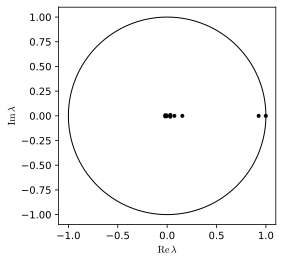

In [66]:
figure, axes = plt.subplots()
c = plt.Circle((0,0), 1, fill=False, color='k')
axes.set_aspect(1)
axes.plot(np.real(Lambda), np.imag(Lambda), 'k.')
axes.add_patch(c)
axes.set_xlabel(r'$\rm{Re}\, \lambda$')
axes.set_ylabel(r'$\rm{Im}\, \lambda$')

In [74]:
y_i, y_j = LazyTensor(snapshots[None, 1:, :]), LazyTensor(test_pts[:, None, :])
Phi = (-((y_i - y_j) ** 2).sum(2) / 2).exp()  # Symbolic (N,N) Gaussian kernel matrix
CVs = Phi@np.abs(W)

[pyKeOps] Compiling libKeOpsnumpy5d2a1d56d7 in /home/novelli/.cache/pykeops-1.5-cpython-38:
       formula: Sum_Reduction((Exp((Minus(Sum(Square((Var(0,4278,1) - Var(1,4278,0))))) / IntCst(2))) * Var(2,10,1)),0)
       aliases: Var(0,4278,1); Var(1,4278,0); Var(2,10,1); 
       dtype  : float32
... 
Done.


In [75]:
from scipy.stats import gaussian_kde
def f(x):
    kde = gaussian_kde(CVs[:,x])
    bounds = (CVs[:,x].min(),CVs[:,x].max())
    padding = 0
    cv_sample = np.linspace(bounds[0] - padding, bounds[1] + padding, 200)
    #print(kde.factor)
    plt.plot(cv_sample, -kde.logpdf(cv_sample), 'k-')
    plt.margins(0)
    plt.xlabel(f"Kernel_DMD_{x}")
    plt.ylabel(r"Fes $[K_{\rm{B}}T]$")
    print(kde.factor)
widgets.interact(f, x=widgets.IntSlider(min=0, max=CVs.shape[1] - 1, step=1, value=0));

interactive(children=(IntSlider(value=0, description='x', max=9), Output()), _dom_classes=('widget-interact',)…

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from stateinterpreter import Classifier, identify_metastable_states, load_dataframe, descriptors_from_traj, sample
from stateinterpreter.plot import plot_states, plot_combination_states_features
from stateinterpreter.visualize import visualize_features

In [78]:
chignolin_data_path = '../data/md_datasets/chignolin-unbiased/'
traj_dict = {
        'trajectory' : chignolin_data_path+'CLN025-0-protein-ALL.dcd',
        'topology' : chignolin_data_path+'CLN025-0-protein.pdb'
    }
stride = 25
#Compute descriptors
descriptors, feats_info = descriptors_from_traj(traj_dict, descriptors=['hbonds_contacts'], stride=stride)

Computing Hydrogen bonds contacts
Donors: [0, 15, 23, 36, 44, 70, 85, 91, 99, 106, 112, 120, 130, 147, 160]
Acceptors: [  0  15  22  23  36  43  44  52  53  55  56  69  70  81  82  84  85  91
  98  99 105 106 112 119 120 130 143 145 146 147 160]
Descriptors: (20990, 318)


In [79]:
import pandas as pd
col_names = [f"Kernel_DMD_{idx}" for idx in range(CVs.shape[1])]
colvars = pd.DataFrame(CVs, columns=col_names)

DEV >>> Finding Local Minima
DEV >>> Basin Assignment
Found 2 local minima with selected populations:
	Basin 0 -> 1710 configurations.
	Basin 1 -> 11857 configurations.


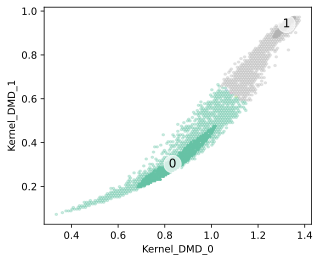

In [82]:
cv_list = ["Kernel_DMD_0","Kernel_DMD_1"]#, "Kernel_DMD_2"]
kBT = 2.8
states_labels = identify_metastable_states(colvars, cv_list, kBT, fes_cutoff=0.5*kBT, bw_method=0.25, optimizer_kwargs={'num_init' : 200})
plot_states(colvars, states_labels, cv_list)

Optimizing Lasso Estimator: 100%|██████████| 25/25 [00:00<00:00, 125.55it/s]


Accuracy: 100%
State 0:
[64.98% ]  HB_CONTACT ASP3-O -- GLY7-N
[32.189%]  HB_CONTACT TYR1-O -- TYR10-N
[2.831% ]  HB_CONTACT ASP3-N -- THR8-O
State 1:
[64.98% ]  HB_CONTACT ASP3-O -- GLY7-N
[32.189%]  HB_CONTACT TYR1-O -- TYR10-N
[2.831% ]  HB_CONTACT ASP3-N -- THR8-O


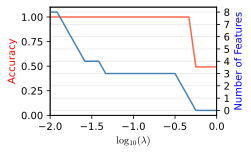

In [83]:
sample_obj, features_names, classes_names = sample(descriptors, states_labels, 500, states_subset=[0,1])
regularizers = np.geomspace(0.01, 1, 25)
classifier = Classifier(sample_obj, features_names, classes_names)
classifier.compute(regularizers, max_iter= 10000, quadratic_kernel=False)
classifier.plot();
reg = 10**(-0.5)
classifier.print_selected(reg)

In [84]:
visualize_features(traj[::stride], states_labels, classifier.classes, classifier._get_selected(reg), feats_info, state=0)

NGLWidget(max_frame=1)